<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/ML_(Stock_Prices_Stationary).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O ibm.csv https://lazyprogrammer.me/course_files/sp500sub.csv

--2024-07-22 05:37:07--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘ibm.csv’

ibm.csv             100%[===================>]  24.29M   139MB/s    in 0.2s    

2024-07-22 05:37:07 (139 MB/s) - ‘ibm.csv’ saved [25473876/25473876]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
df0 = pd.read_csv('ibm.csv')
df0.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
1,2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2,2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
3,2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
4,2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [ ]:
# Let's choose IBM data for this.
df = df0[df0['Name'] == 'IBM'][['Close']].copy()
df.head()

,Close
17655,132.449997
17656,130.850006
17657,130.000000
17658,129.550003
17659,130.850006


In [ ]:
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()

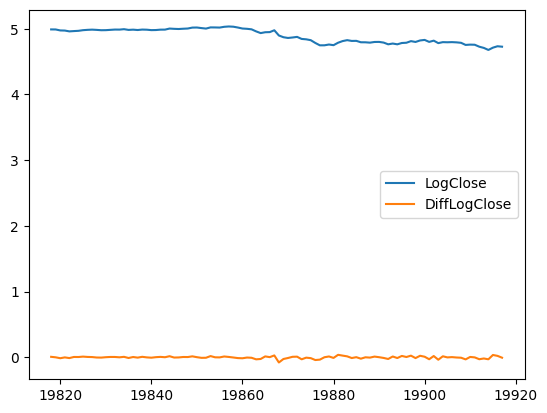

In [ ]:
df[['LogClose', 'DiffLogClose']][-100:].plot();

In [ ]:
df.shape

(2263, 3)

In [ ]:
N_test = 12
train = df[:-N_test]
test = df[-N_test:]

In [ ]:
series = df['DiffLogClose'][1:].to_numpy()
series.shape

(2262,)

In [ ]:
# Let's choose the last 21 lags because it is unpredictable, doesn't have any trend of period

T = 21
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)


(2241, 21) (2241,)


In [ ]:
X_train, X_test = X[:-N_test], X[-N_test:]
Y_train, Y_test = Y[:-N_test], Y[-N_test:]

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
train_idx[:T+1] = False

In [ ]:
# Let's try now the Linear Regression first
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_train, Y_train)

0.00910676388568643

In [ ]:
lr.score(X_test, Y_test)

-0.10647843085489161

In [ ]:
df['ShiftLogSales'] = df['LogClose'].shift(1)
prev = df['ShiftLogSales'].copy()

In [ ]:
prev.head()

17655         NaN
17656    4.886205
17657    4.874052
17658    4.867534
17659    4.864067
Name: ShiftLogSales, dtype: float64

In [ ]:
last_train = train.iloc[-1]['LogClose']
last_train

4.794881036165083

In [ ]:
df.loc[train_idx, 'LR_1step_forecast_train'] = prev[train_idx] + lr.predict(X_train)
df.loc[test_idx, 'LR_1step_forecast_test'] = prev[test_idx] + lr.predict(X_test)

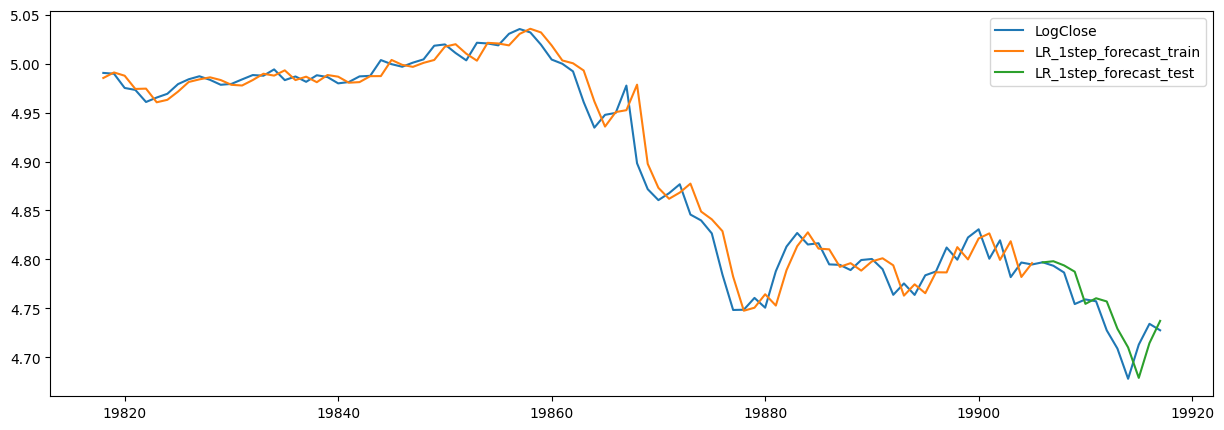

In [ ]:
# Let's Plot it
df[['LogClose', 'LR_1step_forecast_train', 'LR_1step_forecast_test']][-100:].plot(figsize=(15,5));

#### Let's do now Multistep prediction

In [ ]:
last_x = X_test[0]
last_x.shape

(21,)

In [ ]:
multistep_predictions = []

last_x = X_test[0]

while len(multistep_predictions) < N_test:
  p = lr.predict(last_x.reshape(1, -1))[0]
  multistep_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

multistep_predictions = np.array(multistep_predictions)
multistep_predictions.shape

(12,)

In [ ]:
df.loc[test_idx, 'Multistep_prediction'] = last_train + np.cumsum(multistep_predictions)

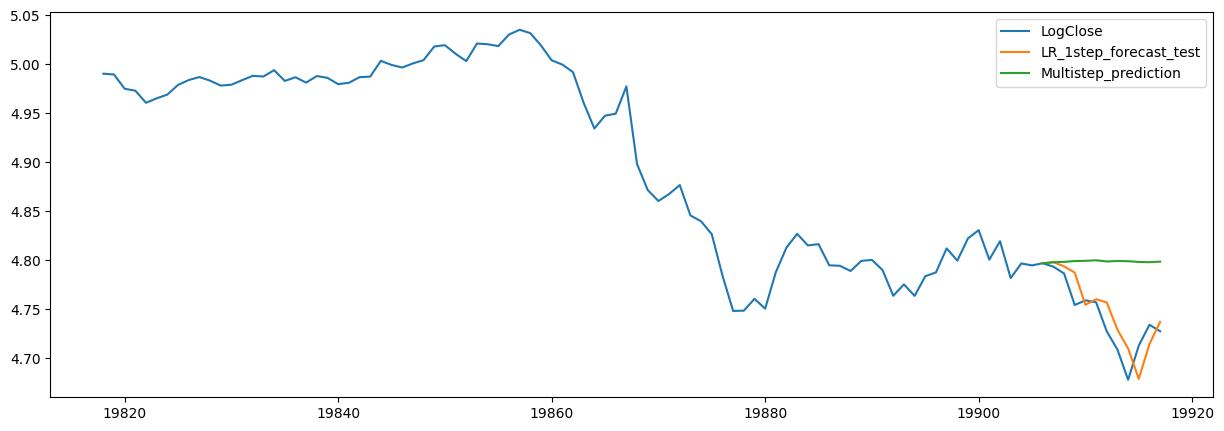

In [ ]:
# Let's Plot them
df[['LogClose', 'LR_1step_forecast_test', 'Multistep_prediction']][-100:].plot(figsize=(15,5));

#### Let's do multistep multi-output forecast

In [ ]:
Tx = T
Ty = N_test
X, Y = [], []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(2230, 21) (2230, 12)


In [ ]:
X_train_m, X_test_m = X[:-1], X[-1:]
Y_train_m, Y_test_m = Y[:-1], Y[-1:]

print(X_train_m.shape, X_test_m.shape, Y_train_m.shape, Y_test_m.shape)

(2229, 21) (1, 21) (2229, 12) (1, 12)


In [ ]:
lr = LinearRegression()
lr.fit(X_train_m, Y_train_m)
lr.score(X_train_m, Y_train_m)

0.010010133087048345

In [ ]:
lr.score(X_test_m, Y_test_m)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [ ]:
r2_score(Y_test_m.flatten(), lr.predict(X_test_m).flatten())

-0.12186690541628598

In [ ]:
# Save Multioutput forecast
df.loc[test_idx, 'Multioutput_forecast'] = last_train + np.cumsum(lr.predict(X_test_m)).flatten()

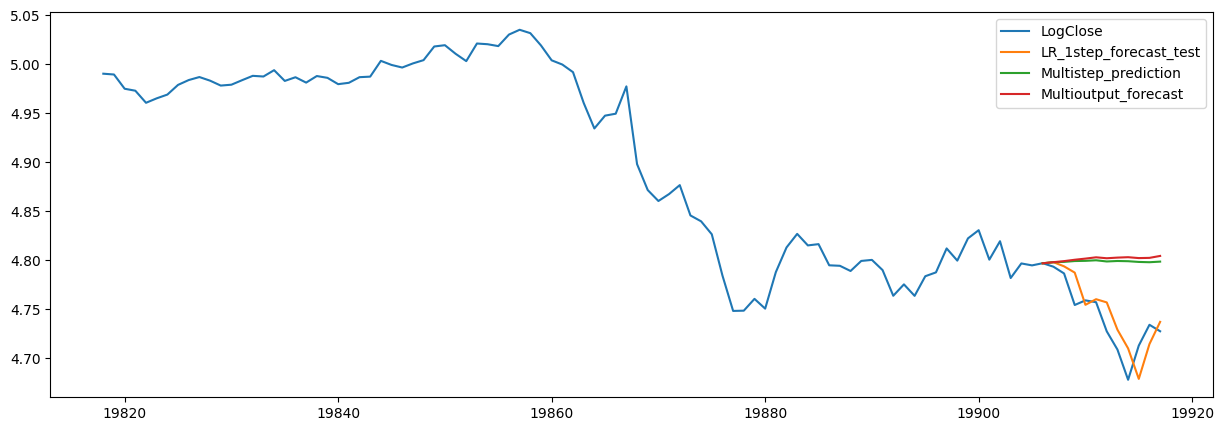

In [ ]:
# Let's plot
df[['LogClose', 'LR_1step_forecast_test', 'Multistep_prediction', 'Multioutput_forecast']][-100:].plot(figsize=(15,5));

In [ ]:
# Let's calculate the mape for all
mape_1step = mean_absolute_percentage_error(df.loc[test_idx, 'LogClose'], df.loc[test_idx, 'LR_1step_forecast_test'])
mape_multistep = mean_absolute_percentage_error(df.loc[test_idx, 'LogClose'], df.loc[test_idx, 'Multistep_prediction'])
mape_multioutput = mean_absolute_percentage_error(df.loc[test_idx, 'LogClose'], df.loc[test_idx, 'Multioutput_forecast'])

print("1Step: ", mape_1step)
print("Multistep: ", mape_multistep)
print("Multioutput: ", mape_multioutput)

1Step:  0.0034867011910453983
Multistep:  0.01142632609085105
Multioutput:  0.011998190671272594
